<a href="https://colab.research.google.com/github/ms1901/CF_Project/blob/main/ParameterTuning/ParameterTining_CARL_MusicalInstruments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install --upgrade tensorflow

     |████████████████████████████████| 462 kB 5.2 MB/s 


In [ ]:
import numpy as np
import scipy.sparse as sp
import math

import tensorflow as tf
import numpy as np
import sys
from time import time
import os
import matplotlib.pyplot as plt

In [ ]:
print(tf.version)

<module 'tensorflow._api.v2.version' from '/usr/local/lib/python3.7/dist-packages/tensorflow/_api/v2/version/__init__.py'>


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
%cd /content/drive/MyDrive/CF_end_proejct/MusicalInstruments

In [ ]:
from tensorflow.python.client import device_lib

def get_available_devices():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos]

print(get_available_devices())

ExtractData

In [ ]:
class Dataset(object):
    "'extract dataset from file'"

    def __init__(self, max_length, path, word_id_path):
        self.word_id_dict = self.load_word_dict(path + word_id_path)
        print("wordId_dict finished")
        
        self.userReview_dict = self.load_reviews(max_length, len(self.word_id_dict), path + "dataPreprocessingUserReviews.out")
        self.itemReview_dict = self.load_reviews(max_length, len(self.word_id_dict), path + "dataPreprocessingItemReviews.out")
        print("load reviews finished")
        
        self.num_users, self.num_items = len(self.userReview_dict), len(self.itemReview_dict)
        
        self.trainMtrx = self.load_ratingFile_as_mtrx(path + "dataPreprocessingTrainInteraction.out")
        self.valRatings = self.load_ratingFile_as_list(path + "dataPreprocessingValInteraction.out")
        self.testRatings = self.load_ratingFile_as_list(path + "dataPreprocessingTestInteraction.out")

    def load_word_dict(self, path):
        wordId_dict = {}

        with open(path, "r") as f:
            line = f.readline().replace("\n", "")
            while line != None and line != "":
                arr = line.split("\t")
                wordId_dict[arr[0]] = int(arr[1])
                line = f.readline().replace("\n", "")

        return wordId_dict

    def load_reviews(self, max_doc_length, padding_word_id, path):
        entity_review_dict = {}

        with open(path, "r") as f:
            line = f.readline().replace("\n", "")
            while line != None and line != "":
                review = []
                arr = line.split("\t")
                entity = int(arr[0])
                word_list = arr[1].split(" ")

                for i in range(len(word_list)):
                    if (word_list[i] == "" or word_list[i] == None or (not self.word_id_dict[word_list[i]] in self.word_id_dict.keys())):
                        continue
                    review.append(self.word_id_dict.get(word_list[i]))
                    if (len(review) >= max_doc_length):
                        break
                if (len(review) < max_doc_length):
                    review = self.padding_word(max_doc_length, padding_word_id, review)
                entity_review_dict[entity] = review
                line = f.readline().replace("\n", "")
        return entity_review_dict

    def padding_word(self, max_size, max_word_idx, review):
        review.extend([max_word_idx]*(max_size - len(review)))
        return review

    def load_ratingFile_as_mtrx(self, file_path):
        mtrx = sp.dok_matrix((self.num_users, self.num_items), dtype=np.float32)
        with open(file_path, "r") as f:
            line = f.readline()
            line = line.strip()
            while line != None and line != "":
                arr = line.split("\t")
                user, item, rating = int(arr[0]), int(arr[1]), float(arr[2])
                if (rating > 0):
                    mtrx[user, item] = rating
                line = f.readline()

        return mtrx

    def load_ratingFile_as_list(self, file_path):
        rateList = []

        with open(file_path, "r") as f:
            line = f.readline()
            while line != None and line != "":
                arr = line.split("\t")
                user, item = int(arr[0]), int(arr[1])
                rate = float(arr[2])
                rateList.append([user, item, rate])
                line = f.readline()

        return rateList

GetTest

In [ ]:
import math

def get_test_list(batch_size, test_rating, user_reviews, item_reviews):
    user_test_batchs, item_test_batchs, user_input_test_batchs, item_input_test_batchs, rating_input_test_batchs = [], [], [], [], []
    for count in range(int(math.ceil(len(test_rating) / float(batch_size)))):
        user_test, item_test, user_input_test, item_input_test, rating_input_test = [], [], [], [], []
        for idx in range(batch_size):
            index = (count * batch_size + idx)
            if (index >= len(test_rating)):
                break
            rating = test_rating[index]
            user_test.append(rating[0])
            item_test.append(rating[1])
            user_input_test.append(user_reviews.get(rating[0]))
            item_input_test.append(item_reviews.get(rating[1]))
            rating_input_test.append([rating[2]])
        user_test_batchs.append(user_test)
        item_test_batchs.append(item_test)
        user_input_test_batchs.append(user_input_test)
        item_input_test_batchs.append(item_input_test)
        rating_input_test_batchs.append(rating_input_test)
       
    return user_test_batchs, item_test_batchs, user_input_test_batchs, item_input_test_batchs, rating_input_test_batchs

CARL

In [ ]:
def ini_word_embed(num_words, latent_dim):
    word_embeds = np.random.rand(num_words, latent_dim)
    return word_embeds


In [ ]:
def word2vec_word_embed(num_words, latent_dim, path, word_id_dict):
    word2vect_embed_mtrx = np.zeros((num_words, latent_dim))
    with open(path, "r") as f:
        line = f.readline()
        while line != None and line != "":
            arr = line.split("\t")
            row_id = word_id_dict.get(arr[0])
            vect = arr[1].strip().split(" ")
            for i in range(len(vect)):
                word2vect_embed_mtrx[row_id, i] = float(vect[i])
            line = f.readline()

    return word2vect_embed_mtrx

In [ ]:
def get_train_instance(train):
    user_input, item_input, rates = [], [], []

    for (u, i) in train.keys():
        # positive instance
        user_input.append(u)
        item_input.append(i)
        rates.append(train[u,i])
    return user_input, item_input, rates



In [ ]:
def get_train_instance_batch_change(count, batch_size, user_input, item_input, ratings, user_reviews, item_reviews):
    users_batch, items_batch, user_input_batch, item_input_batch, labels_batch = [], [], [], [], []

    for idx in range(batch_size):
        index = (count*batch_size + idx) % len(user_input)
        users_batch.append(user_input[index])
        items_batch.append(item_input[index])
        user_input_batch.append(user_reviews.get(user_input[index]))
        item_input_batch.append(item_reviews.get(item_input[index]))
        labels_batch.append([ratings[index]])

    return users_batch, items_batch, user_input_batch, item_input_batch, labels_batch

In [ ]:
#review.py
def  cnn_model_average(filters, user_reviews_representation_expnd, item_reviews_representation_expnd, W_u, W_i, W_u_1, W_i_1, rand_matrix):
    #convolution layer
    convU = tf.nn.conv2d(user_reviews_representation_expnd, W_u, strides=[1, 1, word_latent_dim, 1], padding='SAME')
    convI = tf.nn.conv2d(item_reviews_representation_expnd, W_i, strides=[1, 1, word_latent_dim, 1], padding='SAME')

    hU = tf.nn.relu(tf.squeeze(convU, 2))
    hI = tf.nn.relu(tf.squeeze(convI, 2))

    # attentive layer
    sec_dim = int(hU.get_shape()[1])
    tmphU = tf.reshape(hU, [-1, filters])
    hU_mul_rand = tf.reshape(tf.matmul(tmphU, rand_matrix), [-1, sec_dim, filters])
    f = tf.matmul(hU_mul_rand, hI, transpose_b=True)
    f = tf.expand_dims(f, -1)
    att1 = tf.tanh(f)

    pool_user = tf.reduce_mean(att1, 2)
    pool_item = tf.reduce_mean(att1, 1)

    user_flat = tf.squeeze(pool_user, -1)
    item_flat = tf.squeeze(pool_item, -1)

    weight_user = tf.nn.softmax(user_flat)
    weight_item = tf.nn.softmax(item_flat)

    weight_user_exp = tf.expand_dims(weight_user, -1)
    weight_item_exp = tf.expand_dims(weight_item, -1)

    hU = tf.expand_dims(hU * weight_user_exp, -1)
    hI = tf.expand_dims(hI * weight_item_exp, -1)

    #abstracting layer
    hU_1 = tf.nn.relu(tf.nn.conv2d(hU, W_u_1, strides=[1, 1, 1, 1], padding='VALID'))
    hI_1 = tf.nn.relu(tf.nn.conv2d(hI, W_i_1, strides=[1, 1, 1, 1], padding='VALID'))

    sec_dim = hU_1.get_shape()[1]

    oU = tf.nn.avg_pool(hU_1, ksize=[1, sec_dim, 1, 1], strides=[1, 1, 1, 1],
        padding='VALID')
    oI = tf.nn.avg_pool(hI_1, ksize=[1, sec_dim, 1, 1], strides=[1, 1, 1, 1],
        padding='VALID')

    att_user = tf.squeeze(oU)
    att_item = tf.squeeze(oI)
    #print "attention", att_user.get_shape(), att_item.get_shape()

    return att_user, att_item

In [ ]:
def eval_model(users, items, users_inputs, items_inputs, dropout_rate, predict_rating, sess, user_batch, item_batch, user_input_batch, item_input_batch, rate_tests, rmses, maes):
    print(sess)
    print("user batch. "+str(user_batch))
    print("item batch "+str(item_batch))
    print("user_input_batch. "+str(user_input_batch))
    print("item_input_batch "+str( item_input_batch))

    print("before session run")
    predicts = sess.run(predict_rating, feed_dict={users: user_batch, items: item_batch, users_inputs: user_input_batch, items_inputs: item_input_batch, dropout_rate:1.0})
    print("after session run")
    #print(predicts)
    row, col = predicts.shape
    for r in range(row):
        rmses.append(pow((predicts[r, 0] - rate_tests[r][0]), 2))
        maes.append(abs((predicts[r, 0] - rate_tests[r][0])))
    print(rmses)
    return rmses, maes


In [ ]:
#combination of interaction.py and review.py
def train_model():
    mae_list=[]
    mse_list=[]
    tf.compat.v1.disable_eager_execution()
    #I and R-----
    users = tf.compat.v1.placeholder(tf.int32, shape=[None])
    items = tf.compat.v1.placeholder(tf.int32, shape=[None])
    users_inputs = tf.compat.v1.placeholder(tf.int32, shape=[None, max_doc_length])
    items_inputs = tf.compat.v1.placeholder(tf.int32, shape=[None, max_doc_length])
    ratings = tf.compat.v1.placeholder(tf.float32, shape=[None, 1])
    
    #R-----
    dropout_rate = tf.compat.v1.placeholder(tf.float32)
    
    #I-----
    user_entity_embedding = tf.Variable(tf.random.normal([num_users, latent_dim], mean=0, stddev=0.02), name="user_entity_embeddings")
    item_entity_embedding = tf.Variable(tf.random.normal([num_items, latent_dim], mean=0, stddev=0.02), name="item_entity_embeddings")
    user_entity_embeds = tf.nn.embedding_lookup(user_entity_embedding, users)
    item_entity_embeds = tf.nn.embedding_lookup(item_entity_embedding, items)
    
    #R-----
    user_bias = tf.Variable(tf.random.normal([num_users, 1], mean=0, stddev=0.02), name="user_bias")
    item_bias = tf.Variable(tf.random.normal([num_items, 1], mean=0, stddev=0.02), name="item_bias")
    user_bs = tf.nn.embedding_lookup(user_bias, users)
    item_bs = tf.nn.embedding_lookup(item_bias, items)
    
    text_embedding = tf.Variable(word_embedding_mtrx, dtype=tf.float32, name="review_text_embeds")
    padding_embedding = tf.Variable(np.zeros([1, word_latent_dim]), dtype=tf.float32)
    text_mask = tf.constant([1.0] * text_embedding.get_shape()[0] + [0.0])
    word_embeddings = tf.concat([text_embedding, padding_embedding], 0)
    word_embeddings = word_embeddings * tf.expand_dims(text_mask, -1)
    user_reviews_representation = tf.nn.embedding_lookup(word_embeddings, users_inputs)
    user_reviews_representation_expnd = tf.expand_dims(user_reviews_representation, -1)
    item_reviews_representation = tf.nn.embedding_lookup(word_embeddings, items_inputs)
    item_reviews_representation_expnd = tf.expand_dims(item_reviews_representation, -1)
    
    # CNN layers
    W_u = tf.Variable(tf.random.truncated_normal([window_size, word_latent_dim, 1, num_filters], stddev=0.3), name="review_W_u")
    W_i = tf.Variable(tf.random.truncated_normal([window_size, word_latent_dim, 1, num_filters], stddev=0.3), name="review_W_i")
    W_u_1 = tf.Variable(tf.random.truncated_normal([window_size, num_filters, 1, num_filters], stddev=0.3), name="review_W_u_1")
    W_i_1 = tf.Variable(tf.random.truncated_normal([window_size, num_filters, 1, num_filters], stddev=0.3), name="review_W_i_1")
    # b = tf.Variable(tf.constant(0.1, shape=[self.num_filters]))
    rand_matrix = tf.Variable(tf.random.truncated_normal([num_filters, num_filters], stddev=0.3), name="review_rand_matrix")

    user_embeds, item_embeds = cnn_model_average(num_filters, user_reviews_representation_expnd, item_reviews_representation_expnd, W_u, W_i, W_u_1, W_i_1, rand_matrix)
    
    #shared MLP layer
    W_mlp = tf.Variable(tf.random.normal([num_filters, latent_dim], mean=0, stddev=0.02), name="review_W_mlp")
    W_mlp = tf.nn.dropout(W_mlp, dropout_rate)
    b_mlp = tf.Variable(tf.constant(0.1, shape=[latent_dim]), name="review_b_mlp")

    user_embeds = tf.nn.relu(tf.matmul(user_embeds, W_mlp) + b_mlp)
    item_embeds = tf.nn.relu(tf.matmul(item_embeds, W_mlp) + b_mlp)

    embeds_sum = tf.concat([tf.multiply(user_embeds, item_embeds), user_embeds, item_embeds], 1, name="concat_embed")
    #I
    entity_embeds_sum = tf.concat([tf.multiply(user_entity_embeds, item_entity_embeds), user_entity_embeds, item_entity_embeds],1)

    #FM layer
    #R---
    w_0 = tf.Variable(tf.zeros(1), name="review_w_0")
    w_1 = tf.Variable(tf.random.truncated_normal([1, latent_dim * 3], stddev=0.3), name="review_w_1")
    v = tf.Variable(tf.random.truncated_normal([latent_dim * 3, latent_dim * 3], stddev=0.3), name="review_v")
    
    #I---
    w_entity_0 = tf.Variable(tf.zeros(1), name="entity_w_0")
    w_entity_1 = tf.Variable(tf.random.truncated_normal([1, latent_dim*3], stddev=0.3), name="entity_w_1")
    v_entity = tf.Variable(tf.random.truncated_normal([latent_dim*3, v_dim], stddev=0.3), name="entity_v")
    
    #I---
    J_e_1 = w_entity_0 + tf.matmul(entity_embeds_sum, w_entity_1, transpose_b=True)
    #R---
    J_1 = w_0 + tf.matmul(embeds_sum, w_1, transpose_b=True)
    
    #I---
    entity_embeds_sum_1 = tf.expand_dims(entity_embeds_sum, -1)
    entity_embeds_sum_2 = tf.expand_dims(entity_embeds_sum, 1)
    #R---
    embeds_sum_1 = tf.expand_dims(embeds_sum, -1)
    embeds_sum_2 = tf.expand_dims(embeds_sum, 1)
    
    #I---
    J_e_2 = tf.reduce_sum(tf.reduce_sum(tf.multiply(tf.matmul(entity_embeds_sum_1, entity_embeds_sum_2), tf.matmul(v_entity, v_entity, transpose_b=True)),2), 1, keepdims=True)
    #J_e_3 = tf.trace(tf.multiply(tf.matmul(entity_embeds_sum_1, entity_embeds_sum_2), tf.matmul(v_entity, v_entity, transpose_b=True))) 
    
    #R---
    J_2 = tf.reduce_sum(tf.reduce_sum(tf.multiply(tf.matmul(embeds_sum_1, embeds_sum_2), tf.matmul(v, v, transpose_b=True)),2), 1, keepdims=True)
    #J_3 = tf.trace(tf.multiply(tf.matmul(embeds_sum_1, embeds_sum_2), tf.matmul(v, v, transpose_b=True)))
    #R---
    J_total = (J_1 + 0.5 * (J_2))
    
    #I---
    J_e_total = (J_e_1 + 0.5 * (J_e_2))
    
    
    numerator = J_total + J_e_total
    predict_rating = tf.divide(J_total, numerator) * J_total + tf.divide(J_e_total,numerator) * J_e_total + user_bs + item_bs
    loss = tf.reduce_mean(tf.math.squared_difference(predict_rating, ratings))
    loss += lambda_1 * (tf.nn.l2_loss(W_i_1) + tf.nn.l2_loss(W_u_1) + tf.nn.l2_loss(user_entity_embedding) + tf.nn.l2_loss(item_entity_embedding) + tf.nn.l2_loss(W_u) + tf.nn.l2_loss(W_i) + tf.nn.l2_loss(v) + tf.nn.l2_loss(v_entity) + tf.nn.l2_loss(rand_matrix) + tf.nn.l2_loss(user_bs) + tf.nn.l2_loss(item_bs))
    
    train_step = tf.compat.v1.train.RMSPropOptimizer(learning_rate).minimize(loss)
    saver = tf.compat.v1.train.Saver()
    
    init = tf.compat.v1.global_variables_initializer()
    with tf.compat.v1.Session() as sess:
        sess.run(init)

        for e in range(epochs):
            t = time()
            loss_total = 0.0
            count = 0.0
            
            for i in range(int(math.ceil(len(user_input) / float(batch_size)))):
                user_batch, item_batch, user_input_batch, item_input_batch, rates_batch = get_train_instance_batch_change(i, batch_size,user_input, item_input, rateings, user_reviews,item_reviews)
                _, loss_val, words = sess.run([train_step, loss, word_embeddings], feed_dict={users: user_batch, items: item_batch, users_inputs: user_input_batch, items_inputs: item_input_batch, ratings: rates_batch, dropout_rate:drop_out})
                loss_total += loss_val
                count += 1.0

            t1 = time()            
            #LOOK FROM HERE 
            val_mses, val_maes = [], []
            for i in range(len(user_input_val)):
                #eval_model(users, items, users_inputs, items_inputs, dropout_rate, predict_rating, sess, user_vals[i], item_vals[i], user_input_val[i], item_input_val[i], rating_input_val[i], val_mses, val_maes)
                #predicts = sess.run(predict_rating, feed_dict={users: user_batch, items: item_batch, users_inputs: user_input_batch, items_inputs: item_input_batch, dropout_rate:1.0})
                predicts = sess.run(predict_rating, feed_dict={users: user_vals[i], items: item_vals[i], users_inputs: user_input_val[i], items_inputs: item_input_val[i], ratings: rating_input_val[i], dropout_rate: drop_out})
                #print(predicts)
                row, col = predicts.shape
                for r in range(row):
                    val_mses.append(pow((predicts[r, 0] - rating_input_val[i][r][0]), 2))
                    val_maes.append(abs((predicts[r, 0] - rating_input_val[i][r][0])))
            val_mse = np.array(val_mses).mean()            
            t2 = time()            
            mses, maes = [], []
            for i in range(len(user_input_test)):
                #eval_model(users, items, users_inputs, items_inputs, dropout_rate, predict_rating, sess, user_tests[i], item_tests[i], user_input_test[i], item_input_test[i], rating_input_test[i], mses, maes)
                predicts_test = sess.run(predict_rating, feed_dict={users: user_tests[i], items: item_tests[i], users_inputs: user_input_test[i], items_inputs: item_input_test[i], ratings: rating_input_test[i], dropout_rate: drop_out})
                #print(predicts)
                row, col = predicts_test.shape
                for r in range(row):
                    mses.append(pow((predicts_test[r, 0] - rating_input_test[i][r][0]), 2))
                    maes.append(abs((predicts_test[r, 0] - rating_input_test[i][r][0])))
                    
            mse = np.array(mses).mean()
            mae = np.array(maes).mean()
            t3 = time()
            mae_list.append(mae)
            mse_list.append(mse)
            print("epoch%d train time: %.3fs test time: %.3f  loss = %.3f val_mse = %.3f mse = %.3f mae = %.3f"%(e, (t1 - t), (t3 - t2), loss_total/count, val_mse, mse, mae))
        avg_mae=sum(mae_list) / len(mae_list)
        avg_mse=sum(mse_list)/len(mse_list)
        print("MAE "+str(avg_mae))
        print("MSE "+str(avg_mse))

In [ ]:
%ls

In [ ]:
print(sys.path[0])

Varying EPOCHS

In [ ]:
if __name__ == "__main__":
    print(sys.path[0])
    os.environ["CUDA_VISIBLE_DEVICES"] = "0"
    word_latent_dim = 300
    latent_dim = 15
    max_doc_length = 300
    num_filters = 50
    window_size = 3
    v_dim = 50
    learning_rate = 0.001
    lambda_1 = 0.01 #normally we set from [0.05, 0.01, 0.005, 0.001]
    drop_out = 0.8
    batch_size = 200
    epochs = 60
    
    # loading data
    firTime = time()
    dataSet = Dataset(max_doc_length, sys.path[0], "dataPreprocessingWordDict.out")
    word_dict, user_reviews, item_reviews, train, valRatings, testRatings = dataSet.word_id_dict, dataSet.userReview_dict, dataSet.itemReview_dict, dataSet.trainMtrx, dataSet.valRatings, dataSet.testRatings
    secTime = time()

    num_users, num_items = train.shape
    print("load data: %.3fs" % (secTime - firTime))
    print(num_users, num_items)
    print(latent_dim)

    #load word embeddings
    word_embedding_mtrx = ini_word_embed(len(word_dict), word_latent_dim)
    # word_embedding_mtrx = word2vec_word_embed(len(word_dict), word_latent_dim,
    #                                           "Directory of pretrained WordEmbedding.out",
    #                                           word_dict)

    print( "shape", word_embedding_mtrx.shape)

    # get train instances
    user_input, item_input, rateings = get_train_instance(train)
    print (len(user_input), len(item_input), len(rateings))

    # get test/val instances
    user_vals, item_vals, user_input_val, item_input_val, rating_input_val = get_test_list(200, valRatings, user_reviews, item_reviews)
    user_tests, item_tests, user_input_test, item_input_test, rating_input_test = get_test_list(200, testRatings, user_reviews, item_reviews)

    #train & eval model
    train_model()

    epochs = 120
    #train & eval model
    train_model()

    epochs = 180
    #train & eval model
    train_model()

    epochs = 240
    #train & eval model
    train_model()

avg mae over epochs = [60, 120, 180, 240]: [0.67263878922078, 0.6575728313360638, 0.6704969409891884, 0.6613571633089379]
avg mse over epochs = [60, 120, 180, 240]: [0.9045466114775075, 0.876651496498391, 0.8797876351581316, 0.8774045996267481]


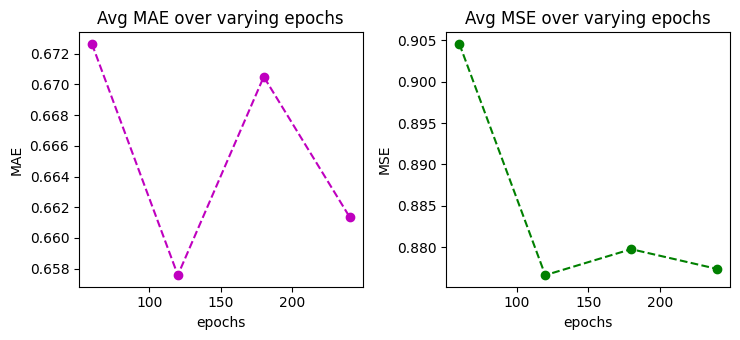

minimum avg mae over epochs = 0.6575728313360638 at epoch = 120 and mse = 0.876651496498391
minimum avg mse over epochs = 0.876651496498391 at epoch = 120 and mae = 0.6575728313360638


In [ ]:
avg_mae_list = [0.67263878922078,0.6575728313360638,0.6704969409891884,0.6613571633089379]
avg_mse_list = [0.9045466114775075,0.876651496498391,0.8797876351581316,0.8774045996267481]
epochs_list = [60, 120, 180, 240]
print(f'avg mae over epochs = [60, 120, 180, 240]: {avg_mae_list}')
print(f'avg mse over epochs = [60, 120, 180, 240]: {avg_mse_list}')
    
plt.rcParams.update({'figure.figsize':(7.5,3.5), 'figure.dpi':100})
fig, axes = plt.subplots(1, 2)
axes[0].plot(epochs_list, avg_mae_list, 'm--o')
axes[0].set_title('Avg MAE over varying epochs')
axes[0].set_xlabel('epochs')
axes[0].set_ylabel('MAE')

axes[1].plot(epochs_list, avg_mse_list, 'g--o')
axes[1].set_title('Avg MSE over varying epochs')
axes[1].set_xlabel('epochs')
axes[1].set_ylabel('MSE')
plt.tight_layout()
plt.show()

index = 0
min = 100
min_index = 0
for i in avg_mae_list:
  if i<min:
    min = i
    min_index = index
  index+=1
print(f'minimum avg mae over epochs = {min} at epoch = {epochs_list[min_index]} and mse = {avg_mse_list[min_index]}')

index = 0
min = 100
min_index = 0
for i in avg_mse_list:
  if i<min:
    min = i
    min_index = index
  index+=1
print(f'minimum avg mse over epochs = {min} at epoch = {epochs_list[min_index]} and mae = {avg_mae_list[min_index]}')

**Results: most optimum number of epochs = 120**

Hence, we will take 120 epochs for tunning other parameters

Varying LAMBDA

In [ ]:
if __name__ == "__main__":
    print(sys.path[0])
    os.environ["CUDA_VISIBLE_DEVICES"] = "0"
    word_latent_dim = 300
    latent_dim = 15
    max_doc_length = 300
    num_filters = 50
    window_size = 3
    v_dim = 50
    learning_rate = 0.001
    lambda_list = [0.001, 0.005, 0.01, 0.05]
    lambda_1 = 0.001 #normally we set from [0.05, 0.01, 0.005, 0.001]
    drop_out = 0.8
    batch_size = 200
    epochs = 120
    avg_mae_list = []
    avg_mse_list = []
    
    # loading data
    firTime = time()
    dataSet = Dataset(max_doc_length, sys.path[0], "dataPreprocessingWordDict.out")
    word_dict, user_reviews, item_reviews, train, valRatings, testRatings = dataSet.word_id_dict, dataSet.userReview_dict, dataSet.itemReview_dict, dataSet.trainMtrx, dataSet.valRatings, dataSet.testRatings
    secTime = time()

    num_users, num_items = train.shape
    print("load data: %.3fs" % (secTime - firTime))
    print(num_users, num_items)
    print(latent_dim)

    #load word embeddings
    word_embedding_mtrx = ini_word_embed(len(word_dict), word_latent_dim)
    # word_embedding_mtrx = word2vec_word_embed(len(word_dict), word_latent_dim,
    #                                           "Directory of pretrained WordEmbedding.out",
    #                                           word_dict)

    print( "shape", word_embedding_mtrx.shape)

    # get train instances
    user_input, item_input, rateings = get_train_instance(train)
    print (len(user_input), len(item_input), len(rateings))

    # get test/val instances
    user_vals, item_vals, user_input_val, item_input_val, rating_input_val = get_test_list(200, valRatings, user_reviews, item_reviews)
    user_tests, item_tests, user_input_test, item_input_test, rating_input_test = get_test_list(200, testRatings, user_reviews, item_reviews)

    #train & eval model
    train_model()

    lambda_1 = 0.005
    #train & eval model
    train_model()

    lambda_1 = 0.01
    #train & eval model
    train_model()

    lambda_1 = 0.05
    #train & eval model
    train_model()


avg mae over lambda = [0.001, 0.005, 0.01, 0.05]: [0.6917452442225022, 0.6721527335859445, 0.6690891103016195, 0.6656870986468989]
avg mse over lambda = [0.001, 0.005, 0.01, 0.05]: [0.9371435783507925, 0.9085042752076795, 0.9119015344716727, 0.8789537832453714]


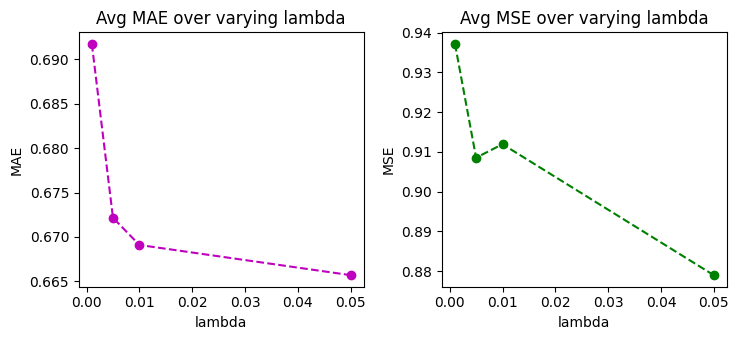

minimum avg mae over lambda = 0.6656870986468989 at lambda = 0.05 and mse = 0.8789537832453714
minimum avg mse over lambda = 0.8789537832453714 at lambda = 0.05 and mae = 0.6656870986468989


In [ ]:
avg_mae_list = [0.6917452442225022,0.6721527335859445,0.6690891103016195,0.6656870986468989]
avg_mse_list = [0.9371435783507925,0.9085042752076795,0.9119015344716727,0.8789537832453714]
lambda_list = [0.001, 0.005, 0.01, 0.05]
print(f'avg mae over lambda = [0.001, 0.005, 0.01, 0.05]: {avg_mae_list}')
print(f'avg mse over lambda = [0.001, 0.005, 0.01, 0.05]: {avg_mse_list}')
    
plt.rcParams.update({'figure.figsize':(7.5,3.5), 'figure.dpi':100})
fig, axes = plt.subplots(1, 2)
axes[0].plot(lambda_list, avg_mae_list, 'm--o')
axes[0].set_title('Avg MAE over varying lambda')
axes[0].set_xlabel('lambda')
axes[0].set_ylabel('MAE')

axes[1].plot(lambda_list, avg_mse_list, 'g--o')
axes[1].set_title('Avg MSE over varying lambda')
axes[1].set_xlabel('lambda')
axes[1].set_ylabel('MSE')
plt.tight_layout()
plt.show()

index = 0
min = 100
min_index = 0
for i in avg_mae_list:
  if i<min:
    min = i
    min_index = index
  index+=1
print(f'minimum avg mae over lambda = {min} at lambda = {lambda_list[min_index]} and mse = {avg_mse_list[min_index]}')

index = 0
min = 100
min_index = 0
for i in avg_mse_list:
  if i<min:
    min = i
    min_index = index
  index+=1
print(f'minimum avg mse over lambda = {min} at lambda = {lambda_list[min_index]} and mae = {avg_mae_list[min_index]}')

Varying latent dimensions

In [ ]:
if __name__ == "__main__":
    print(sys.path[0])
    os.environ["CUDA_VISIBLE_DEVICES"] = "0"
    word_latent_dim = 300
    latent_dim_list = [15, 25, 50, 100, 150, 200, 300]
    latent_dim = 15
    max_doc_length = 300
    num_filters = 50
    window_size = 3
    v_dim = 50
    learning_rate = 0.001
    lambda_1 = 0.01 #normally we set from [0.05, 0.01, 0.005, 0.001]
    drop_out = 0.8
    batch_size = 200
    epochs = 120
    avg_mae_list = []
    avg_mse_list = []
    
    # loading data
    firTime = time()
    dataSet = Dataset(max_doc_length, sys.path[0], "dataPreprocessingWordDict.out")
    word_dict, user_reviews, item_reviews, train, valRatings, testRatings = dataSet.word_id_dict, dataSet.userReview_dict, dataSet.itemReview_dict, dataSet.trainMtrx, dataSet.valRatings, dataSet.testRatings
    secTime = time()

    num_users, num_items = train.shape
    print("load data: %.3fs" % (secTime - firTime))
    print(num_users, num_items)
    print(latent_dim)

    #load word embeddings
    word_embedding_mtrx = ini_word_embed(len(word_dict), word_latent_dim)
    # word_embedding_mtrx = word2vec_word_embed(len(word_dict), word_latent_dim,
    #                                           "Directory of pretrained WordEmbedding.out",
    #                                           word_dict)

    print( "shape", word_embedding_mtrx.shape)

    # get train instances
    user_input, item_input, rateings = get_train_instance(train)
    print (len(user_input), len(item_input), len(rateings))

    # get test/val instances
    user_vals, item_vals, user_input_val, item_input_val, rating_input_val = get_test_list(200, valRatings, user_reviews, item_reviews)
    user_tests, item_tests, user_input_test, item_input_test, rating_input_test = get_test_list(200, testRatings, user_reviews, item_reviews)

    #train & eval model
    train_model()

    latent_dim = 25
    #train & eval model
    train_model()

    latent_dim = 50
    #train & eval model
    train_model()

    latent_dim = 100
    #train & eval model
    train_model()

    latent_dim = 150
    #train & eval model
    train_model()

    latent_dim = 200
    #train & eval model
    train_model()

    latent_dim = 300
    #train & eval model
    train_model()

avg mae over latent dimensions = [15, 25, 50, 100, 150, 200, 300]: [0.6703910703211292, 0.6417340249712058, 0.6446848607940466, 0.6521739528760172, 0.6534780474929722, 0.6601080517745804, 0.7465802265738355]
avg mse over latent dimensions = [15, 25, 50, 100, 150, 200, 300]: [0.8937859865065624, 0.8435149712299163, 0.8345654187641376, 0.8325071872419542, 0.8385010161584376, 0.8580438932003519, 1.1190624304580759]


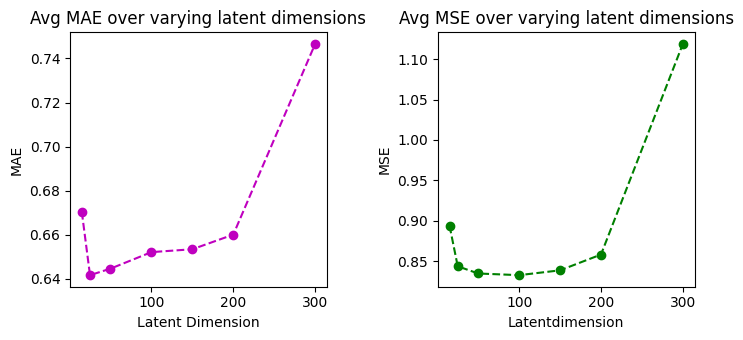

minimum avg mae over latent dimensions = 0.6417340249712058 at latent dimension = 25 and mse = 0.8435149712299163
minimum avg mse over latent dimensions = 0.8325071872419542 at laten dimension = 100 and mae = 0.6521739528760172


In [ ]:
avg_mae_list = [0.6703910703211292,0.6417340249712058,0.6446848607940466,0.6521739528760172,0.6534780474929722,0.6601080517745804,0.7465802265738355]
avg_mse_list = [0.8937859865065624,0.8435149712299163,0.8345654187641376,0.8325071872419542,0.8385010161584376,0.8580438932003519,1.1190624304580759]
latent_dim_list = [15, 25, 50, 100, 150, 200, 300]
print(f'avg mae over latent dimensions = [15, 25, 50, 100, 150, 200, 300]: {avg_mae_list}')
print(f'avg mse over latent dimensions = [15, 25, 50, 100, 150, 200, 300]: {avg_mse_list}')
    
plt.rcParams.update({'figure.figsize':(7.5,3.5), 'figure.dpi':100})
fig, axes = plt.subplots(1, 2)
axes[0].plot(latent_dim_list, avg_mae_list, 'm--o')
axes[0].set_title('Avg MAE over varying latent dimensions')
axes[0].set_xlabel('Latent Dimension')
axes[0].set_ylabel('MAE')

axes[1].plot(latent_dim_list, avg_mse_list, 'g--o')
axes[1].set_title('Avg MSE over varying latent dimensions')
axes[1].set_xlabel('Latentdimension')
axes[1].set_ylabel('MSE')
plt.tight_layout()
plt.show()

index = 0
min = 100
min_index = 0
for i in avg_mae_list:
  if i<min:
    min = i
    min_index = index
  index+=1
print(f'minimum avg mae over latent dimensions = {min} at latent dimension = {latent_dim_list[min_index]} and mse = {avg_mse_list[min_index]}')

index = 0
min = 100
min_index = 0
for i in avg_mse_list:
  if i<min:
    min = i
    min_index = index
  index+=1
print(f'minimum avg mse over latent dimensions = {min} at laten dimension = {latent_dim_list[min_index]} and mae = {avg_mae_list[min_index]}')

Varying dropout rate

In [ ]:
if __name__ == "__main__":
    print(sys.path[0])
    os.environ["CUDA_VISIBLE_DEVICES"] = "0"
    word_latent_dim = 300
    latent_dim = 25
    max_doc_length = 300
    num_filters = 50
    window_size = 3
    v_dim = 50
    learning_rate = 0.001
    lambda_1 = 0.01 #normally we set from [0.05, 0.01, 0.005, 0.001]
    drop_out_list = [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
    drop_out = 0.2
    batch_size = 200
    epochs = 120
    avg_mae_list = []
    avg_mse_list = []
    
    # loading data
    firTime = time()
    dataSet = Dataset(max_doc_length, sys.path[0], "dataPreprocessingWordDict.out")
    word_dict, user_reviews, item_reviews, train, valRatings, testRatings = dataSet.word_id_dict, dataSet.userReview_dict, dataSet.itemReview_dict, dataSet.trainMtrx, dataSet.valRatings, dataSet.testRatings
    secTime = time()

    num_users, num_items = train.shape
    print("load data: %.3fs" % (secTime - firTime))
    print(num_users, num_items)
    print(latent_dim)

    #load word embeddings
    word_embedding_mtrx = ini_word_embed(len(word_dict), word_latent_dim)
    # word_embedding_mtrx = word2vec_word_embed(len(word_dict), word_latent_dim,
    #                                           "Directory of pretrained WordEmbedding.out",
    #                                           word_dict)

    print( "shape", word_embedding_mtrx.shape)

    # get train instances
    user_input, item_input, rateings = get_train_instance(train)
    print (len(user_input), len(item_input), len(rateings))

    # get test/val instances
    user_vals, item_vals, user_input_val, item_input_val, rating_input_val = get_test_list(200, valRatings, user_reviews, item_reviews)
    user_tests, item_tests, user_input_test, item_input_test, rating_input_test = get_test_list(200, testRatings, user_reviews, item_reviews)

    #train & eval model
    train_model()

    drop_out = 0.3
    #train & eval model
    train_model()

    drop_out = 0.4
    #train & eval model
    train_model()
    
    drop_out = 0.5
    #train & eval model
    train_model()

    drop_out = 0.6
    #train & eval model
    train_model()

    drop_out = 0.7
    #train & eval model
    train_model()

    drop_out = 0.8
    #train & eval model
    train_model()

    drop_out = 0.9
    #train & eval model
    train_model()

avg mae over drop out rate = [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]: [0.6473535991289385, 0.6462885581716403, 0.646125925587498, 0.648242944637231, 0.6468460681261841, 0.6451121722214029, 0.6450075646495476, 0.6438893512912129]
avg mse over drop out rate = [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]: [0.8417769896193309, 0.8400303072379663, 0.8424704858834791, 0.8473395536526483, 0.8453683014557611, 0.8448926652475073, 0.8439745115714613, 0.8435993414965349]


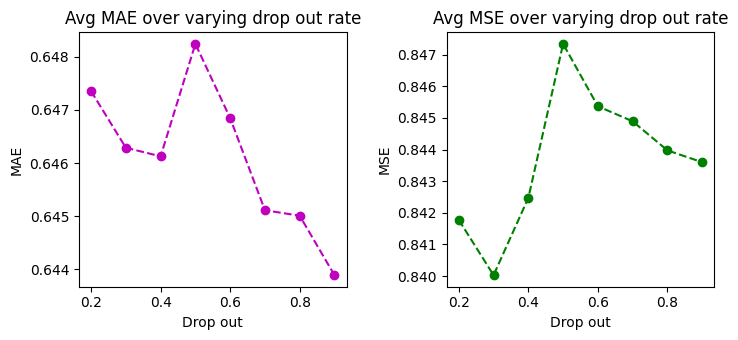

minimum avg mae over drop out rates = 0.6438893512912129 at drop out rate = 0.9 and mse = 0.8435993414965349
minimum avg mse over drop out rates = 0.8400303072379663 at drop out rate = 0.3 and mae = 0.6462885581716403


In [ ]:
avg_mae_list = [0.6473535991289385,0.6462885581716403,0.646125925587498,0.648242944637231,0.6468460681261841,0.6451121722214029,0.6450075646495476,0.6438893512912129]
avg_mse_list = [0.8417769896193309,0.8400303072379663,0.8424704858834791,0.8473395536526483,0.8453683014557611,0.8448926652475073,0.8439745115714613,0.8435993414965349]
drop_out_list = [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
print(f'avg mae over drop out rate = [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]: {avg_mae_list}')
print(f'avg mse over drop out rate = [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]: {avg_mse_list}')
    
plt.rcParams.update({'figure.figsize':(7.5,3.5), 'figure.dpi':100})
fig, axes = plt.subplots(1, 2)
axes[0].plot(drop_out_list, avg_mae_list, 'm--o')
axes[0].set_title('Avg MAE over varying drop out rate')
axes[0].set_xlabel('Drop out')
axes[0].set_ylabel('MAE')

axes[1].plot(drop_out_list, avg_mse_list, 'g--o')
axes[1].set_title('Avg MSE over varying drop out rate')
axes[1].set_xlabel('Drop out')
axes[1].set_ylabel('MSE')
plt.tight_layout()
plt.show()

index = 0
min = 100
min_index = 0
for i in avg_mae_list:
  if i<min:
    min = i
    min_index = index
  index+=1
print(f'minimum avg mae over drop out rates = {min} at drop out rate = {drop_out_list[min_index]} and mse = {avg_mse_list[min_index]}')

index = 0
min = 100
min_index = 0
for i in avg_mse_list:
  if i<min:
    min = i
    min_index = index
  index+=1
print(f'minimum avg mse over drop out rates = {min} at drop out rate = {drop_out_list[min_index]} and mae = {avg_mae_list[min_index]}')

Varying sliding window

In [ ]:
if __name__ == "__main__":
    print(sys.path[0])
    os.environ["CUDA_VISIBLE_DEVICES"] = "0"
    word_latent_dim = 300
    latent_dim = 15
    max_doc_length = 300
    num_filters = 50
    window_size_list = [2, 3, 5, 10]
    window_size = 2
    v_dim = 50
    learning_rate = 0.001
    lambda_1 = 0.01 #normally we set from [0.05, 0.01, 0.005, 0.001]
    drop_out = 0.3
    batch_size = 200
    epochs = 120
    avg_mae_list = []
    avg_mse_list = []
    
    # loading data
    firTime = time()
    dataSet = Dataset(max_doc_length, sys.path[0], "dataPreprocessingWordDict.out")
    word_dict, user_reviews, item_reviews, train, valRatings, testRatings = dataSet.word_id_dict, dataSet.userReview_dict, dataSet.itemReview_dict, dataSet.trainMtrx, dataSet.valRatings, dataSet.testRatings
    secTime = time()

    num_users, num_items = train.shape
    print("load data: %.3fs" % (secTime - firTime))
    print(num_users, num_items)
    print(latent_dim)

    #load word embeddings
    word_embedding_mtrx = ini_word_embed(len(word_dict), word_latent_dim)
    # word_embedding_mtrx = word2vec_word_embed(len(word_dict), word_latent_dim,
    #                                           "Directory of pretrained WordEmbedding.out",
    #                                           word_dict)

    print( "shape", word_embedding_mtrx.shape)

    # get train instances
    user_input, item_input, rateings = get_train_instance(train)
    print (len(user_input), len(item_input), len(rateings))

    # get test/val instances
    user_vals, item_vals, user_input_val, item_input_val, rating_input_val = get_test_list(200, valRatings, user_reviews, item_reviews)
    user_tests, item_tests, user_input_test, item_input_test, rating_input_test = get_test_list(200, testRatings, user_reviews, item_reviews)

    #train & eval model
    train_model()
    
    window_size = 3
    #train & eval model
    train_model()

    window_size = 5
    #train & eval model
    train_model()

    window_size = 10
    #train & eval model
    train_model()


wordId_dict finished
load reviews finished
load data: 0.790s
1429 900
15
shape (17236, 300)
8220 8220 8220
epoch0 train time: 28.161s test time: 0.310  loss = 40.220 val_mse = 6.162 mse = 5.982 mae = 2.337
epoch1 train time: 2.240s test time: 0.263  loss = 28.534 val_mse = 0.706 mse = 0.807 mae = 0.685
epoch2 train time: 2.251s test time: 0.325  loss = 25.393 val_mse = 0.710 mse = 0.838 mae = 0.629
epoch3 train time: 2.287s test time: 0.266  loss = 20.529 val_mse = 0.697 mse = 0.836 mae = 0.624
epoch4 train time: 2.278s test time: 0.285  loss = 15.593 val_mse = 0.685 mse = 0.833 mae = 0.620
epoch5 train time: 2.094s test time: 0.212  loss = 11.642 val_mse = 0.672 mse = 0.830 mae = 0.617
epoch6 train time: 2.168s test time: 0.250  loss = 8.567 val_mse = 0.660 mse = 0.826 mae = 0.615
epoch7 train time: 2.206s test time: 0.287  loss = 6.221 val_mse = 0.647 mse = 0.823 mae = 0.612
epoch8 train time: 2.268s test time: 0.281  loss = 4.473 val_mse = 0.634 mse = 0.819 mae = 0.610
epoch9 train

avg mae over window size = [2, 3, 5, 10]: [0.6726279631623359, 0.6668650505582608, 0.6670122312223744, 0.6683762327373831]
avg mse over window size = [2, 3, 5, 10]: [0.8972756257001998, 0.8743727927447552, 0.8839279905727605, 0.9093795553292144]


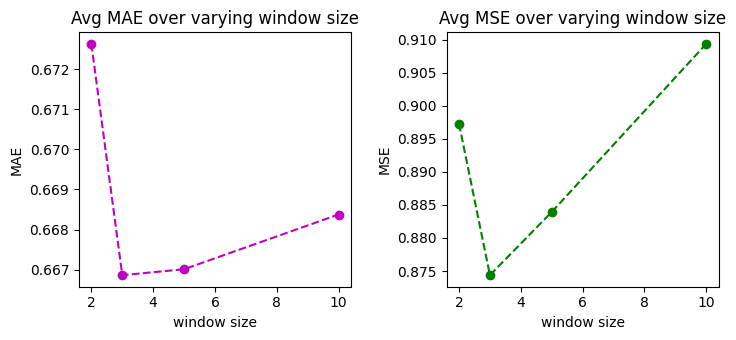

minimum avg mae over window sizes = 0.6668650505582608 at window size = 3 and mse = 0.8743727927447552
minimum avg mse over window sizes = 0.8743727927447552 at window size = 3 and mae = 0.6668650505582608


In [ ]:
avg_mae_list = [0.6726279631623359,0.6668650505582608,0.6670122312223744,0.6683762327373831]
avg_mse_list = [0.8972756257001998,0.8743727927447552,0.8839279905727605,0.9093795553292144]
window_size_list = [2, 3, 5, 10]
print(f'avg mae over window size = [2, 3, 5, 10]: {avg_mae_list}')
print(f'avg mse over window size = [2, 3, 5, 10]: {avg_mse_list}')
    
plt.rcParams.update({'figure.figsize':(7.5,3.5), 'figure.dpi':100})
fig, axes = plt.subplots(1, 2)
axes[0].plot(window_size_list, avg_mae_list, 'm--o')
axes[0].set_title('Avg MAE over varying window size')
axes[0].set_xlabel('window size')
axes[0].set_ylabel('MAE')

axes[1].plot(window_size_list, avg_mse_list, 'g--o')
axes[1].set_title('Avg MSE over varying window size')
axes[1].set_xlabel('window size')
axes[1].set_ylabel('MSE')
plt.tight_layout()
plt.show()

index = 0
min = 100
min_index = 0
for i in avg_mae_list:
  if i<min:
    min = i
    min_index = index
  index+=1
print(f'minimum avg mae over window sizes = {min} at window size = {window_size_list[min_index]} and mse = {avg_mse_list[min_index]}')

index = 0
min = 100
min_index = 0
for i in avg_mse_list:
  if i<min:
    min = i
    min_index = index
  index+=1
print(f'minimum avg mse over window sizes = {min} at window size = {window_size_list[min_index]} and mae = {avg_mae_list[min_index]}')

Varying batch size

In [ ]:
if __name__ == "__main__":
    print(sys.path[0])
    os.environ["CUDA_VISIBLE_DEVICES"] = "0"
    word_latent_dim = 300
    latent_dim = 15
    max_doc_length = 300
    num_filters = 50
    window_size = 3
    v_dim = 50
    learning_rate = 0.001
    lambda_1 = 0.01 #normally we set from [0.05, 0.01, 0.005, 0.001]
    drop_out = 0.4
    batch_size_list = [100, 200, 250, 300, 500]
    batch_size = 100
    epochs = 120
    avg_mae_list = []
    avg_mse_list = []
    
    # loading data
    firTime = time()
    dataSet = Dataset(max_doc_length, sys.path[0], "dataPreprocessingWordDict.out")
    word_dict, user_reviews, item_reviews, train, valRatings, testRatings = dataSet.word_id_dict, dataSet.userReview_dict, dataSet.itemReview_dict, dataSet.trainMtrx, dataSet.valRatings, dataSet.testRatings
    secTime = time()

    num_users, num_items = train.shape
    print("load data: %.3fs" % (secTime - firTime))
    print(num_users, num_items)
    print(latent_dim)

    #load word embeddings
    word_embedding_mtrx = ini_word_embed(len(word_dict), word_latent_dim)
    # word_embedding_mtrx = word2vec_word_embed(len(word_dict), word_latent_dim,
    #                                           "Directory of pretrained WordEmbedding.out",
    #                                           word_dict)

    print( "shape", word_embedding_mtrx.shape)

    # get train instances
    user_input, item_input, rateings = get_train_instance(train)
    print (len(user_input), len(item_input), len(rateings))

    # get test/val instances
    user_vals, item_vals, user_input_val, item_input_val, rating_input_val = get_test_list(200, valRatings, user_reviews, item_reviews)
    user_tests, item_tests, user_input_test, item_input_test, rating_input_test = get_test_list(200, testRatings, user_reviews, item_reviews)

    #train & eval model
    train_model()
    
    batch_size = 200
    #train & eval model
    train_model()

    batch_size = 250
    #train & eval model
    train_model()

    batch_size = 300
    #train & eval model
    train_model()

    batch_size = 500
    #train & eval model
    train_model()


wordId_dict finished
load reviews finished
load data: 0.421s
1429 900
15
shape (17236, 300)
8220 8220 8220
epoch0 train time: 3.748s test time: 0.231  loss = 46.898 val_mse = 0.718 mse = 0.809 mae = 0.706
epoch1 train time: 2.348s test time: 0.232  loss = 33.010 val_mse = 0.695 mse = 0.817 mae = 0.648
epoch2 train time: 2.328s test time: 0.240  loss = 19.579 val_mse = 0.679 mse = 0.813 mae = 0.647
epoch3 train time: 2.333s test time: 0.233  loss = 10.527 val_mse = 0.665 mse = 0.811 mae = 0.645
epoch4 train time: 2.330s test time: 0.233  loss = 5.326 val_mse = 0.652 mse = 0.809 mae = 0.643
epoch5 train time: 2.339s test time: 0.239  loss = 2.644 val_mse = 0.641 mse = 0.807 mae = 0.641
epoch6 train time: 2.344s test time: 0.230  loss = 1.466 val_mse = 0.631 mse = 0.806 mae = 0.639
epoch7 train time: 2.341s test time: 0.241  loss = 1.069 val_mse = 0.621 mse = 0.804 mae = 0.638
epoch8 train time: 2.366s test time: 0.241  loss = 0.982 val_mse = 0.611 mse = 0.803 mae = 0.637
epoch9 train ti

avg mae over batch size = [100, 200, 250, 300, 500]: [0.6706516464902944, 0.676441739175758, 0.6734362793687677, 0.6835599727335231, 0.7079244255340712]
avg mse over batch size = [100, 200, 250, 300, 500]: [0.8582003155918776, 0.9149648766520511, 0.8849713845655508, 0.923109117160049, 1.0864000925298103]


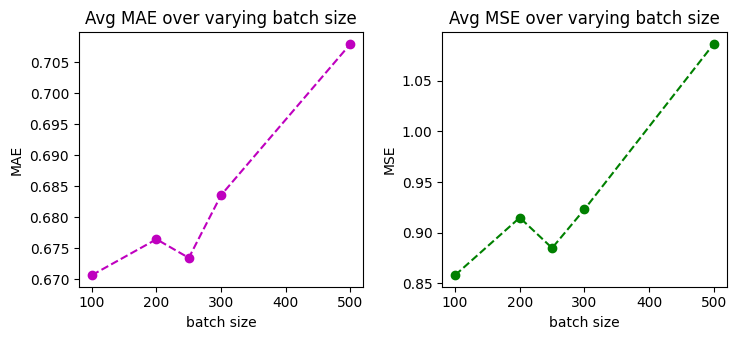

minimum avg mae over batch sizes = 0.6706516464902944 at batch size = 100 and mse = 0.8582003155918776
minimum avg mse over batch sizes = 0.8582003155918776 at batch size = 100 and mae = 0.6706516464902944


In [ ]:
avg_mae_list = [0.6706516464902944,0.676441739175758,0.6734362793687677,0.6835599727335231,0.7079244255340712]
avg_mse_list = [0.8582003155918776,0.9149648766520511,0.8849713845655508,0.923109117160049,1.0864000925298103]
batch_size_list = [100, 200, 250, 300, 500]
print(f'avg mae over batch size = [100, 200, 250, 300, 500]: {avg_mae_list}')
print(f'avg mse over batch size = [100, 200, 250, 300, 500]: {avg_mse_list}')
    
plt.rcParams.update({'figure.figsize':(7.5,3.5), 'figure.dpi':100})
fig, axes = plt.subplots(1, 2)
axes[0].plot(batch_size_list, avg_mae_list, 'm--o')
axes[0].set_title('Avg MAE over varying batch size')
axes[0].set_xlabel('batch size')
axes[0].set_ylabel('MAE')

axes[1].plot(batch_size_list, avg_mse_list, 'g--o')
axes[1].set_title('Avg MSE over varying batch size')
axes[1].set_xlabel('batch size')
axes[1].set_ylabel('MSE')
plt.tight_layout()
plt.show()

index = 0
min = 100
min_index = 0
for i in avg_mae_list:
  if i<min:
    min = i
    min_index = index
  index+=1
print(f'minimum avg mae over batch sizes = {min} at batch size = {batch_size_list[min_index]} and mse = {avg_mse_list[min_index]}')

index = 0
min = 100
min_index = 0
for i in avg_mse_list:
  if i<min:
    min = i
    min_index = index
  index+=1
print(f'minimum avg mse over batch sizes = {min} at batch size = {batch_size_list[min_index]} and mae = {avg_mae_list[min_index]}')

varying learning rate

In [ ]:
if __name__ == "__main__":
    print(sys.path[0])
    os.environ["CUDA_VISIBLE_DEVICES"] = "0"
    word_latent_dim = 300
    latent_dim = 15
    max_doc_length = 300
    num_filters = 50
    window_size = 2
    v_dim = 50
    learning_rate_list = [0.0001,0.001, 0.01, 0.1, 1]
    learning_rate = 0.0001
    lambda_1 = 0.01 #normally we set from [0.05, 0.01, 0.005, 0.001]
    drop_out = 0.4
    batch_size = 250
    epochs = 120
    avg_mae_list = []
    avg_mse_list = []
    
    # loading data
    firTime = time()
    dataSet = Dataset(max_doc_length, sys.path[0], "dataPreprocessingWordDict.out")
    word_dict, user_reviews, item_reviews, train, valRatings, testRatings = dataSet.word_id_dict, dataSet.userReview_dict, dataSet.itemReview_dict, dataSet.trainMtrx, dataSet.valRatings, dataSet.testRatings
    secTime = time()

    num_users, num_items = train.shape
    print("load data: %.3fs" % (secTime - firTime))
    print(num_users, num_items)
    print(latent_dim)

    #load word embeddings
    word_embedding_mtrx = ini_word_embed(len(word_dict), word_latent_dim)
    # word_embedding_mtrx = word2vec_word_embed(len(word_dict), word_latent_dim,
    #                                           "Directory of pretrained WordEmbedding.out",
    #                                           word_dict)

    print( "shape", word_embedding_mtrx.shape)

    # get train instances
    user_input, item_input, rateings = get_train_instance(train)
    print (len(user_input), len(item_input), len(rateings))

    # get test/val instances
    user_vals, item_vals, user_input_val, item_input_val, rating_input_val = get_test_list(200, valRatings, user_reviews, item_reviews)
    user_tests, item_tests, user_input_test, item_input_test, rating_input_test = get_test_list(200, testRatings, user_reviews, item_reviews)

    #train & eval model
    train_model()
    
    learning_rate = 0.001
    #train & eval model
    train_model()

    learning_rate = 0.01
    #train & eval model
    train_model()

    learning_rate = 0.1
    #train & eval model
    train_model()

    learning_rate = 1
    #train & eval model
    train_model()


wordId_dict finished
load reviews finished
load data: 0.798s
1429 900
15
shape (17236, 300)
8220 8220 8220
epoch0 train time: 33.895s test time: 0.269  loss = 44.074 val_mse = 17.193 mse = 16.792 mae = 3.998
epoch1 train time: 2.160s test time: 0.266  loss = 43.304 val_mse = 16.287 mse = 15.900 mae = 3.884
epoch2 train time: 2.174s test time: 0.275  loss = 42.243 val_mse = 15.191 mse = 14.821 mae = 3.743
epoch3 train time: 2.144s test time: 0.271  loss = 40.841 val_mse = 13.979 mse = 13.631 mae = 3.581
epoch4 train time: 2.333s test time: 0.247  loss = 39.141 val_mse = 12.688 mse = 12.363 mae = 3.403
epoch5 train time: 2.175s test time: 0.314  loss = 37.320 val_mse = 11.325 mse = 11.027 mae = 3.209
epoch6 train time: 2.139s test time: 0.300  loss = 35.439 val_mse = 9.906 mse = 9.636 mae = 2.993
epoch7 train time: 2.246s test time: 0.282  loss = 33.522 val_mse = 8.453 mse = 8.216 mae = 2.754
epoch8 train time: 2.198s test time: 0.250  loss = 31.598 val_mse = 6.997 mse = 6.795 mae = 2.4

avg mae over learning rate = [0.0001, 0.001, 0.01]: [0.9203527193228334, 0.6790124515731466, 0.7015336043973978]
avg mse over learning rate = [0.0001, 0.001, 0.01]: [1.7403357890959923, 0.9089488348980893, 1.0069037516419685]


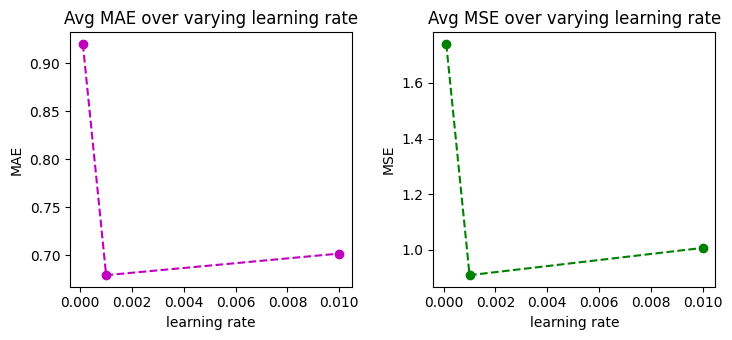

minimum avg mae over learning rates = 0.6790124515731466 at learning rate = 0.001 and mse = 0.9089488348980893
minimum avg mse over learning rates = 0.9089488348980893 at learning rate = 0.001 and mae = 0.6790124515731466


In [ ]:
avg_mae_list = [0.9203527193228334,0.6790124515731466,0.7015336043973978]
avg_mse_list = [1.7403357890959923,0.9089488348980893,1.0069037516419685]
learning_rate_list = [0.0001, 0.001, 0.01]
print(f'avg mae over learning rate = [0.0001, 0.001, 0.01]: {avg_mae_list}')
print(f'avg mse over learning rate = [0.0001, 0.001, 0.01]: {avg_mse_list}')
    
plt.rcParams.update({'figure.figsize':(7.5,3.5), 'figure.dpi':100})
fig, axes = plt.subplots(1, 2)
axes[0].plot(learning_rate_list, avg_mae_list, 'm--o')
axes[0].set_title('Avg MAE over varying learning rate')
axes[0].set_xlabel('learning rate')
axes[0].set_ylabel('MAE')

axes[1].plot(learning_rate_list, avg_mse_list, 'g--o')
axes[1].set_title('Avg MSE over varying learning rate')
axes[1].set_xlabel('learning rate')
axes[1].set_ylabel('MSE')
plt.tight_layout()
plt.show()

index = 0
min = 100
min_index = 0
for i in avg_mae_list:
  if i<min:
    min = i
    min_index = index
  index+=1
print(f'minimum avg mae over learning rates = {min} at learning rate = {learning_rate_list[min_index]} and mse = {avg_mse_list[min_index]}')

index = 0
min = 100
min_index = 0
for i in avg_mse_list:
  if i<min:
    min = i
    min_index = index
  index+=1
print(f'minimum avg mse over learning rates = {min} at learning rate = {learning_rate_list[min_index]} and mae = {avg_mae_list[min_index]}')